<a href="https://colab.research.google.com/github/hargurjeet/Maersk/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forcasting - Vessel Delays**

The purpose of this task is to give us a gauge of your skills and experience as a data scientist.

The Following notebook is used for building ml model for forcasting expected vessel waiting time at the Post.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Explainatory Data Analysis](#3)
  4. [Feature Engineering](#4)
  5. [Train a baseline model](#5)
  6. [Evaluate Results & Experimenting with NN](#6)
  7. [Summary](#7)
  8. [Future Work](#8)
  9. [Reference](#9)

# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

The dataset primiarly conatins the vessel transport information across various geographies. The dataset contains the following features

- 'call_id': ID variable to identify a Vessel at a Port.
- 'arrival_date': arrival date of a vessel at a port.
- 'departure_date': departure date of a vessel at a port.
- 'arrival_time': arrival timestamp of a vessel at a port.
- 'departure_time': departure timestamp of a vessel at a port.
- 'imo': Vessel identifier
- 'vessel_name’: Name of the vessel
- 'vessel_type’: Type of the vessel
- 'Country': Name of the country
- 'CountryCode': Identifier of the Country
- 'Port': Name of The Port
- 'Terminal': Name of the Terminal
- 'Duration': Duration of vessel stay in a Port
- 'Service_name': Name of the service
- 'length': vessel length
- 'vesteu': capacity of a vessel
- 'prev_departure_time': departure time of a vessel from the previous port.
- 'prev_port': Previous port visited by the vessel
- 'prev_arrival_time': arrival time of a vessel at the previous port.
- 'prev_duration': Duration of vessel stay in previous Port
- 'prev_leg_duration': Time taken to travel from previous port to current port
- 'prev_leg_distance_nm': Distance travelled from previous port to current port
- 'prev_leg_stationary_hours': waiting time at the vicinity of Port to get a place to unload the cargo
- 'prev_call_id': ID variable to identify a Vessel at its previous Port.
- 'next_port': Next port visited by the vessel
- 'next_arrival_time': arrival time of a vessel at the next port.
- 'next_duration': Duration of vessel stay in next Port.
- 'next_leg_duration': Time taken to travel from current port to next port
- 'next_leg_distance_nm': Distance travelled from current port to next port
- 'next_leg_stationary_hours': waiting time at the vicinity of next Port to get a place to unload the cargo.
- 'next_call_id': ID variable to identify a Vessel at its next Port.

# 2: Loading the dataset Preprocessing <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

The dataset has been loaded on my github [repo](https://github.com/hargurjeet/Maersk).

I also import other standard imports to perfrom data analysis, model building...etc

In [1]:
!pip install -q gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [2]:
## Libraries to import data, preprocessing and building visuals
import pandas as pd
import numpy as np
from git import Repo
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
# Clone the GitHub repository
repo_url = 'https://github.com/hargurjeet/Maersk'
repo_dir = 'Maersk'
Repo.clone_from(repo_url, repo_dir)

<git.repo.base.Repo '/content/Maersk/.git'>

In [4]:
## Reading the data and parsing the data and time columns
file_path = "/content/Maersk/vessel_data.csv"
date_cols = ['arrival_date', 'departure_date']

dtypes = {
    'imo': 'object',
}

vessel_data = pd.read_csv(file_path, parse_dates=date_cols, dtype=dtypes,)
pd.set_option('display.max_columns', None)
vessel_data.head(2)


,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19+00:00,2022-01-07 21:04:26+00:00,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05+00:00,4496,Haiphong,2021-12-13 17:02:55+00:00,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14+00:00,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14+00:00,2022-02-19 03:02:28+00:00,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26+00:00,4496,Xiamen,2022-01-05 23:00:19+00:00,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41+00:00,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265


In [5]:
# fixing datatypes of columns datatime columns
def remove_timezone_info(data):
    return data.str[:-6]

def convert_to_datetime(data):
    return pd.to_datetime(data, format="%Y-%m-%d %H:%M:%S", errors='coerce')

columns = ['arrival_time', 'departure_time', 'prev_arrival_time', 'prev_departure_time', 'next_arrival_time']

for col in columns:
    vessel_data[col] = remove_timezone_info(vessel_data[col])
    vessel_data[col] = convert_to_datetime(vessel_data[col])


In [6]:
vessel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494042 entries, 0 to 494041
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Unnamed: 0                    494042 non-null  int64         
 1   call_id                       494042 non-null  object        
 2   arrival_date                  494042 non-null  datetime64[ns]
 3   departure_date                494042 non-null  datetime64[ns]
 4   arrival_time                  493604 non-null  datetime64[ns]
 5   departure_time                493614 non-null  datetime64[ns]
 6   imo                           494042 non-null  object        
 7   vessel_name_ais               494042 non-null  object        
 8   vessel_type_ais               494039 non-null  object        
 9   Country                       494042 non-null  object        
 10  CountryCode                   493669 non-null  object        
 11  Port         

## **Observations**

- All the columns datatypes seems to be parsed correctly
- Few columns seems to have null values, but in terms of % nulls there are very minimal.
- Overall dataset size is about half million

In [7]:
vessel_data.head(2)

,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19,2022-01-07 21:04:26,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05,4496,Haiphong,2021-12-13 17:02:55,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14,2022-02-19 03:02:28,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26,4496,Xiamen,2022-01-05 23:00:19,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265


# 3: Explainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

I have performed EDA in a seprate notebook. To access that notebook click [here](https://github.com/hargurjeet/Maersk/blob/main/Solution_Notebook.ipynb)

# 4: Feature Engineering <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

While some features were developed while performing EDA and the same processed dataset is imported in the current notebook. I build some more featues that might add values to the data and help ml models to learn

## 4.1 Building Featuers from data columns

In [8]:
## Splitting data and time
def part_of_dates(df, column):
  """ Extrace Year, Month, day, weekday and hour from a date value """
  df[column+ '_year']= df[column].dt.year
  df[column+ '_month']= df[column].dt.month
  df[column+ '_day']= df[column].dt.day
  df[column+ '_week']= df[column].dt.weekday
  df[column+ '_hour']= df[column].dt.hour

part_of_dates(vessel_data, 'arrival_date')
part_of_dates(vessel_data, 'departure_date')
part_of_dates(vessel_data, 'arrival_time')
part_of_dates(vessel_data, 'departure_time')
part_of_dates(vessel_data, 'prev_departure_time')
part_of_dates(vessel_data, 'prev_arrival_time')
part_of_dates(vessel_data, 'next_arrival_time')

In [ ]:
vessel_data.head(2)

,Unnamed: 0,call_id,arrival_date,departure_date,arrival_time,departure_time,imo,vessel_name_ais,vessel_type_ais,Country,CountryCode,Port,Terminal,Duration,Service_name,length,prev_departure_time,vesteu,prev_port,prev_arrival_time,prev_duration,prev_leg_duration,prev_leg_distance_nm,prev_leg_stationary_hours,prev_call_id,next_port,next_arrival_time,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,next_call_id,total_duration_shipment,total_duration_shipment_days,total_distance_shipment,arrival_date_year,arrival_date_month,arrival_date_day,arrival_date_week,arrival_date_hour,departure_date_year,departure_date_month,departure_date_day,departure_date_week,departure_date_hour,arrival_time_year,arrival_time_month,arrival_time_day,arrival_time_week,arrival_time_hour,departure_time_year,departure_time_month,departure_time_day,departure_time_week,departure_time_hour,prev_departure_time_year,prev_departure_time_month,prev_departure_time_day,prev_departure_time_week,prev_departure_time_hour,prev_arrival_time_year,prev_arrival_time_month,prev_arrival_time_day,prev_arrival_time_week,prev_arrival_time_hour,next_arrival_time_year,next_arrival_time_month,next_arrival_time_day,next_arrival_time_week,next_arrival_time_hour
0,0,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,2022-01-05,2022-01-07,2022-01-05 23:00:19,2022-01-07 21:04:26,9525376,SAFMARINE CHAMBAL,Container Ship,China,CN,Xiamen,Xiamen Songyu Container Terminal,46.068611,ML - TPX,249.12,2021-12-14 07:00:05,4496,Haiphong,2021-12-13 17:02:55,13.952778,544.003889,1598.620103,28,705238686bb73f1947352631d015ad9485d78a9c,Los Angeles,2022-02-10 12:01:14,207.020556,806.946667,7407.903024,201.0,c77797c9b9822d7a799e6f7664f7d6be5f73f270,1846.992500,76.958021,9006.523126,2022,1,5,2,0,2022,1,7,4,0,2022.0,1.0,5.0,2.0,23.0,2022.0,1.0,7.0,4.0,21.0,2021.0,12.0,14.0,1.0,7.0,2021.0,12.0,13.0,0.0,17.0,2022.0,2.0,10.0,3.0,12.0
1,1,c77797c9b9822d7a799e6f7664f7d6be5f73f270,2022-02-10,2022-02-19,2022-02-10 12:01:14,2022-02-19 03:02:28,9525376,SAFMARINE CHAMBAL,Container Ship,United States,US,Los Angeles,Apmt Pier 400,207.020556,ML - TPX,249.12,2022-01-07 21:04:26,4496,Xiamen,2022-01-05 23:00:19,46.068611,806.946667,7407.903024,201,7b75a18f54d78c79df4e9ceb29c65c60d6b5c7ae,Qingdao,2022-03-08 22:27:41,105.949167,427.420278,5967.080241,25.0,0dccb61f51069f40de6592464459777a2eb73334,1819.405278,75.808553,13374.983265,2022,2,10,3,0,2022,2,19,5,0,2022.0,2.0,10.0,3.0,12.0,2022.0,2.0,19.0,5.0,3.0,2022.0,1.0,7.0,4.0,21.0,2022.0,1.0,5.0,2.0,23.0,2022.0,3.0,8.0,1.0,22.0


## 4.2 Feature around Vessel duration

In [9]:
## Creating a feature by adding the duration of previous, current and next port to calculate total time take by the shipment.
prev_duration_features = ['prev_duration', 'prev_leg_duration', 'prev_leg_stationary_hours',]
vessel_data['total_pre_duration_vessel'] = vessel_data[prev_duration_features].sum(axis=1)

# 5: Train a baseline model <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [10]:
vessel_data.columns

Index(['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date',
       'arrival_time', 'departure_time', 'imo', 'vessel_name_ais',
       'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal',
       'Duration', 'Service_name', 'length', 'prev_departure_time', 'vesteu',
       'prev_port', 'prev_arrival_time', 'prev_duration', 'prev_leg_duration',
       'prev_leg_distance_nm', 'prev_leg_stationary_hours', 'prev_call_id',
       'next_port', 'next_arrival_time', 'next_duration', 'next_leg_duration',
       'next_leg_distance_nm', 'next_leg_stationary_hours', 'next_call_id',
       'total_duration_shipment', 'total_duration_shipment_days',
       'total_distance_shipment', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day', 'arrival_date_week', 'arrival_date_hour',
       'departure_date_year', 'departure_date_month', 'departure_date_day',
       'departure_date_week', 'departure_date_hour', 'arrival_time_year',
       'arrival_time_month', 'arrival_time_da

In [11]:
## The function count the uniques values across categorical columns
def calculate_count_and_percentage(data, column_name):
    # Calculate value counts and total count
    value_counts = data[column_name].value_counts()
    total_count = len(data)

    # Calculate percentage values
    percentage_values = (value_counts / total_count) * 100

    # Create a new DataFrame with count and percentage values
    result_df = pd.DataFrame({f'{column_name}_Count': value_counts, f'{column_name}_Percentage': percentage_values})

    return result_df

# Example usage
# Assuming vessel_data is your DataFrame
output_vessel_type = calculate_count_and_percentage(vessel_data, 'vessel_type_ais')
output_Country = calculate_count_and_percentage(vessel_data, 'Country')
output_Port = calculate_count_and_percentage(vessel_data, 'Port')
output_prev_port = calculate_count_and_percentage(vessel_data, 'prev_port')
# output_next_port = calculate_count_and_percentage(vessel_data, 'next_port')

In [12]:
## The function puts the categroies into a general category 'others' expect the top n values
def categorize_top_values(column_name, data, top_n):
    # Get the top n values
    top_values = data[column_name].value_counts().nlargest(top_n).index

    # Create a new column with top values and 'Others'
    data[f'{column_name}_Categorized'] = np.where(data[column_name].isin(top_values), data[column_name], 'Others')


# Example usage
# Assuming vessel_data is your DataFrame
categorize_top_values('vessel_type_ais', vessel_data, 2)
categorize_top_values('Country', vessel_data, 3)
categorize_top_values('Port', vessel_data, 3)
categorize_top_values('prev_port', vessel_data, 3)
# categorize_top_values('next_port', vessel_data, 3)


In [13]:
vessel_data.columns

Index(['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date',
       'arrival_time', 'departure_time', 'imo', 'vessel_name_ais',
       'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal',
       'Duration', 'Service_name', 'length', 'prev_departure_time', 'vesteu',
       'prev_port', 'prev_arrival_time', 'prev_duration', 'prev_leg_duration',
       'prev_leg_distance_nm', 'prev_leg_stationary_hours', 'prev_call_id',
       'next_port', 'next_arrival_time', 'next_duration', 'next_leg_duration',
       'next_leg_distance_nm', 'next_leg_stationary_hours', 'next_call_id',
       'total_duration_shipment', 'total_duration_shipment_days',
       'total_distance_shipment', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day', 'arrival_date_week', 'arrival_date_hour',
       'departure_date_year', 'departure_date_month', 'departure_date_day',
       'departure_date_week', 'departure_date_hour', 'arrival_time_year',
       'arrival_time_month', 'arrival_time_da

In [14]:
## List of columns which are not very relevant and does not contribute to ml training
not_rel = ['Unnamed: 0', 'call_id', 'arrival_date', 'departure_date', 'arrival_time', 'departure_time', 'imo', 'vessel_name_ais',\
           'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal', 'Service_name','prev_departure_time','prev_port', 'prev_arrival_time',\
          'prev_call_id', 'next_port', 'next_call_id',]

target = ['prev_leg_stationary_hours']

In [15]:
# Split data into features and target
X = vessel_data.drop(not_rel + target,axis=1)
y = vessel_data['prev_leg_stationary_hours']

print(X.shape)

(494042, 54)


In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Extract a subset of data as I dont have sufficient computing to train ml model out of the whole dataset
subset_size = 30000  # Define the size of the subset
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_subset = X_train.iloc[subset_indices]
y_subset = y_train.iloc[subset_indices]

# Split the subset data into training and testing sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor()

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model)])

# Fit the model
pipeline.fit(X_train_subset, y_train_subset)

# Predict on the test set
y_pred = pipeline.predict(X_test_subset)

In [18]:
# Evaluate the model
mse = mean_squared_error(y_test_subset, y_pred)
print("Mean Squared Error:", mse)

# Evaluate the model
rmse = mean_squared_error(y_test_subset, y_pred, squared=False)
print("Mean Squared Error:", rmse)

Mean Squared Error: 672.4885952499999
Mean Squared Error: 25.93238506674617


In [22]:
# Extract a subset of data
subset_size = 30000  # Define the size of the subset
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_subset = X_train.iloc[subset_indices]
y_subset = y_train.iloc[subset_indices]

# Split the subset data into training and testing sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
# Create an XGBoost regressor model
xgb_model = xgb.XGBRegressor()

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])

# Fit the model
pipeline.fit(X_train_subset, y_train_subset)

# Predict on the test set
y_pred = pipeline.predict(X_test_subset)

# Evaluate the model
mse = mean_squared_error(y_test_subset, y_pred)
print("Mean Squared Error:", mse)

# Evaluate the model
rmse = mean_squared_error(y_test_subset, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 879.0343528058448
Root Mean Squared Error: 29.6485135007785


# 6: Evaluate Results & Experimenting with NN <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [23]:
# Get feature importance
booster = xgb_model.get_booster()
feature_importance = booster.get_score(importance_type='weight')

# Map feature indices to feature names
feature_names = X_train.columns
feature_importance_named = {feature_names[int(feature[1:])] : importance for feature, importance in feature_importance.items()}

# Sort feature importance
sorted_feature_importance = sorted(feature_importance_named.items(), key=lambda x: x[1], reverse=True)

# Display feature importance
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: prev_leg_duration, Importance: 905.0
Feature: prev_departure_time_hour, Importance: 889.0
Feature: prev_leg_distance_nm, Importance: 729.0
Feature: prev_duration, Importance: 527.0
Feature: Duration, Importance: 295.0
Feature: length, Importance: 221.0
Feature: vesteu, Importance: 147.0
Feature: next_arrival_time, Importance: 145.0
Feature: next_leg_stationary_hours, Importance: 132.0
Feature: next_leg_duration, Importance: 115.0
Feature: next_duration, Importance: 110.0
Feature: departure_date_week, Importance: 106.0
Feature: arrival_date_week, Importance: 100.0
Feature: total_duration_shipment_days, Importance: 94.0
Feature: arrival_time_week, Importance: 92.0
Feature: next_leg_distance_nm, Importance: 90.0
Feature: prev_departure_time_week, Importance: 89.0
Feature: arrival_date_month, Importance: 81.0
Feature: departure_time_week, Importance: 73.0
Feature: prev_departure_time_month, Importance: 72.0
Feature: departure_date_month, Importance: 71.0
Feature: departure_time_mo

<ipython-input-24-97c8fb2c16f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


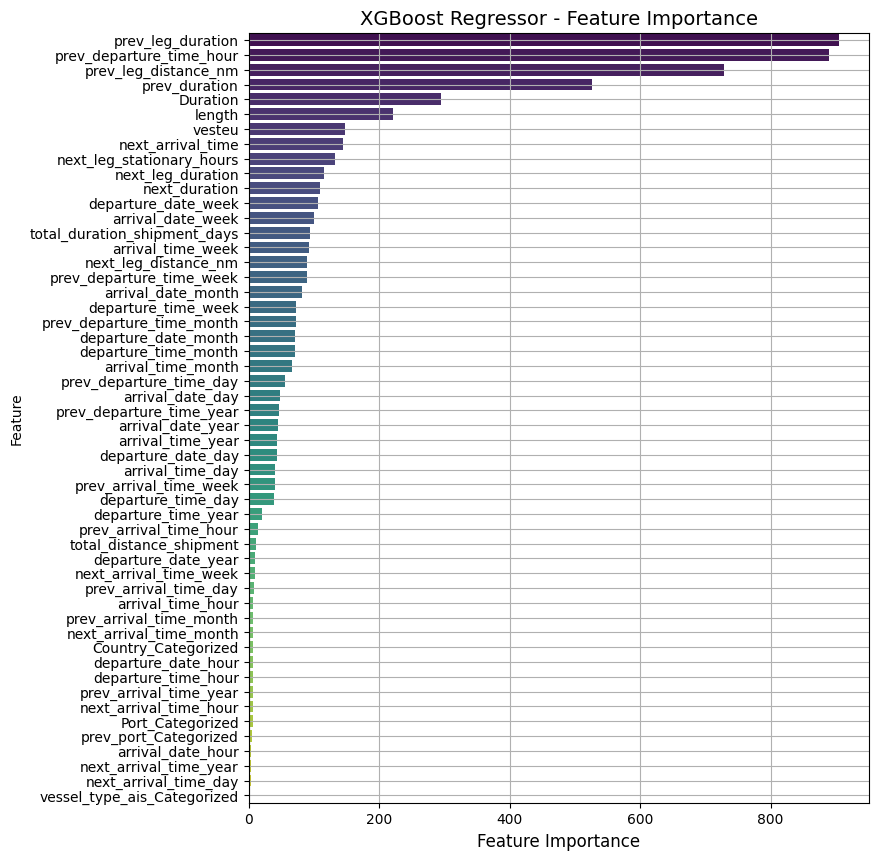

In [24]:
# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'])

# Plot feature importance
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=10)
plt.title('XGBoost Regressor - Feature Importance', fontsize=14)
plt.grid()
plt.show()

In [27]:
# Define the number of folds for cross-validation
kf = KFold(n_splits=5)

# Initialize a list to store RMSE values for each fold
fold_rmses = []

# Perform 5-fold cross-validation using the pipeline
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_subset)):
    X_train_fold, X_val_fold = X_train_subset.iloc[train_idx], X_train_subset.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_subset.iloc[train_idx], y_train_subset.iloc[val_idx]

    pipeline.fit(X_train_fold, y_train_fold)

    val_predictions = pipeline.predict(X_val_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, val_predictions))
    fold_rmses.append(fold_rmse)

    print(f'Fold {fold_idx + 1} RMSE: {fold_rmse}')

# Calculate the average RMSE
avg_rmse = np.mean(fold_rmses)

# Fit the pipeline on the full training set and evaluate on the test set
pipeline.fit(X_train_subset, y_train_subset)
test_predictions = pipeline.predict(X_test_subset)
test_rmse = np.sqrt(mean_squared_error(y_test_subset, test_predictions))

print(f'Average RMSE from cross-validation with pipeline: {avg_rmse}')
print(f'RMSE on the test set with pipeline: {test_rmse}')

Fold 1 RMSE: 37.76657585613622
Fold 2 RMSE: 39.712803765988575
Fold 3 RMSE: 26.620513113858237
Fold 4 RMSE: 38.148157286532204
Fold 5 RMSE: 36.89623917785439
Average RMSE from cross-validation with pipeline: 35.82885784007392
RMSE on the test set with pipeline: 29.6485135007785


## 6.1 Neaural Nets

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract a subset of data
subset_size = 30000  # Define the size of the subset
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_subset = X_train.iloc[subset_indices]
y_subset = y_train.iloc[subset_indices]

# Split the subset data into training and testing sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, \
                                                                                test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# # Create a SimpleImputer instance with median strategy
imputer = SimpleImputer(strategy='median')

# # Fit the imputer on the specified columns
imputer.fit(X_train_subset[numeric_features])

# # Transform the specified columns by filling missing values
X_train_subset[numeric_features] = imputer.transform(X_train_subset[numeric_features])
X_test_subset[numeric_features] = imputer.transform(X_test_subset[numeric_features])

# # Standardize the features
scaler = StandardScaler()
X_train_subset[numeric_features] = scaler.fit_transform(X_train_subset[numeric_features])
X_test_subset[numeric_features] = scaler.transform(X_test_subset[numeric_features])


In [ ]:
X_test_subset[numeric_features].shape

(6000, 39)

In [ ]:
# Create a SimpleImputer instance with most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train_subset[categorical_features])
X_train_subset[categorical_features] = imputer.transform(X_train_subset[categorical_features])
X_test_subset[categorical_features] = imputer.transform(X_test_subset[categorical_features])

# One-Hot Encoding using Pandas get_dummies
encoded_df_train = pd.get_dummies(X_train_subset[categorical_features], dtype=int)
encoded_df_test = pd.get_dummies(X_test_subset[categorical_features], dtype=int)

In [ ]:
encoded_df_train.head(2)

,vessel_type_ais_Categorized_Container Ship,vessel_type_ais_Categorized_General Cargo,vessel_type_ais_Categorized_Others,Country_Categorized_China,Country_Categorized_Others,Country_Categorized_Singapore,Country_Categorized_United States,Port_Categorized_Busan,Port_Categorized_Others,Port_Categorized_Shanghai,Port_Categorized_Singapore,prev_port_Categorized_Busan,prev_port_Categorized_Others,prev_port_Categorized_Shanghai,prev_port_Categorized_Singapore
74113,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
287098,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [ ]:
# X_train_transformed = X_train_subset[numeric_features] + encoded_df_train
X_train_transformed = pd.concat([X_train_subset[numeric_features].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test_transformed = pd.concat([X_test_subset[numeric_features].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)
print(X_train_transformed.shape, X_test_transformed.shape)

(24000, 54) (6000, 54)


In [ ]:
X_test_transformed.head(3)

,Duration,length,vesteu,prev_duration,prev_leg_duration,prev_leg_distance_nm,next_duration,next_leg_duration,next_leg_distance_nm,next_leg_stationary_hours,total_duration_shipment,total_duration_shipment_days,total_distance_shipment,arrival_time_year,arrival_time_month,arrival_time_day,arrival_time_week,arrival_time_hour,departure_time_year,departure_time_month,departure_time_day,departure_time_week,departure_time_hour,prev_departure_time_year,prev_departure_time_month,prev_departure_time_day,prev_departure_time_week,prev_departure_time_hour,prev_arrival_time_year,prev_arrival_time_month,prev_arrival_time_day,prev_arrival_time_week,prev_arrival_time_hour,next_arrival_time_year,next_arrival_time_month,next_arrival_time_day,next_arrival_time_week,next_arrival_time_hour,total_pre_duration_vessel,vessel_type_ais_Categorized_Container Ship,vessel_type_ais_Categorized_General Cargo,vessel_type_ais_Categorized_Others,Country_Categorized_China,Country_Categorized_Others,Country_Categorized_Singapore,Country_Categorized_United States,Port_Categorized_Busan,Port_Categorized_Others,Port_Categorized_Shanghai,Port_Categorized_Singapore,prev_port_Categorized_Busan,prev_port_Categorized_Others,prev_port_Categorized_Shanghai,prev_port_Categorized_Singapore
0,0.109562,0.664919,0.323736,-0.757484,0.463264,1.044496,-0.434548,-0.432470,-0.507578,-0.179798,-0.047199,-0.047199,0.341655,0.874623,-1.682744,1.047427,-0.490166,1.563563,0.867978,-1.685868,1.151843,-0.003081,1.655147,0.870334,-1.675243,-0.085571,1.501484,0.654266,0.869825,-1.674405,-0.086042,1.502714,-0.064213,0.811185,-1.688204,1.393231,1.01388,-0.062091,0.321410,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False
1,-0.547111,-1.098985,-0.764905,-0.308702,-0.169196,-0.306309,-0.576923,-0.441133,-0.596226,-0.096287,-0.355437,-0.355437,-0.595339,0.874623,-0.795981,0.477936,0.010514,-0.486491,0.867978,-0.798887,0.469612,-0.003081,0.928052,0.870334,-0.788363,0.027843,1.501484,-0.796421,0.869825,-0.787140,-0.086042,1.001719,0.519538,0.811185,-0.802473,0.712709,1.01388,-1.084772,-0.133721,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False
2,10.412173,1.652604,1.308804,0.004070,2.682521,2.326901,0.136088,0.725125,1.920689,-0.315504,2.621051,2.621051,2.788991,-1.143350,0.386370,0.250140,0.010514,0.392103,-1.143171,0.383755,1.492958,-1.512242,-0.089881,-1.077086,0.098518,0.141258,1.501484,0.799334,-1.068323,0.100125,0.027358,1.001719,1.103288,-1.133325,0.673747,-0.534914,1.51634,-0.646480,2.988073,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False


Training Loss: 3.371572494506836, Test Loss: 3.6875855922698975


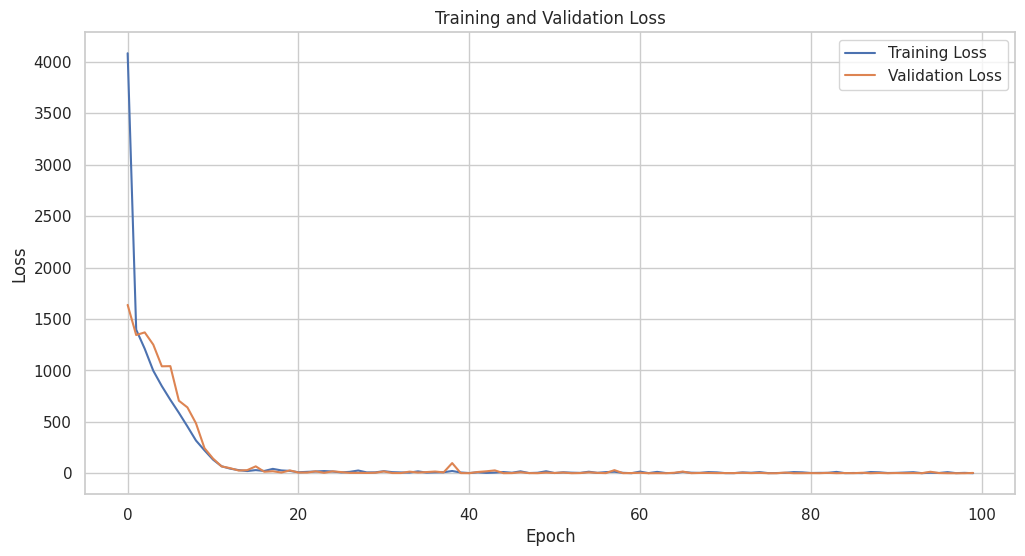

In [ ]:
# Build the neural network model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train_subset.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_transformed, y_train_subset, epochs=100, validation_data=(X_test_transformed,\
                                                                                      y_test_subset), verbose=0)

# Evaluate the model
train_loss = model.evaluate(X_train_transformed, y_train_subset, verbose=0)
test_loss = model.evaluate(X_test_transformed, y_test_subset, verbose=0)
print(f'Training Loss: {train_loss}, Test Loss: {test_loss}')

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

188/188 [==============================] - 1s 3ms/step


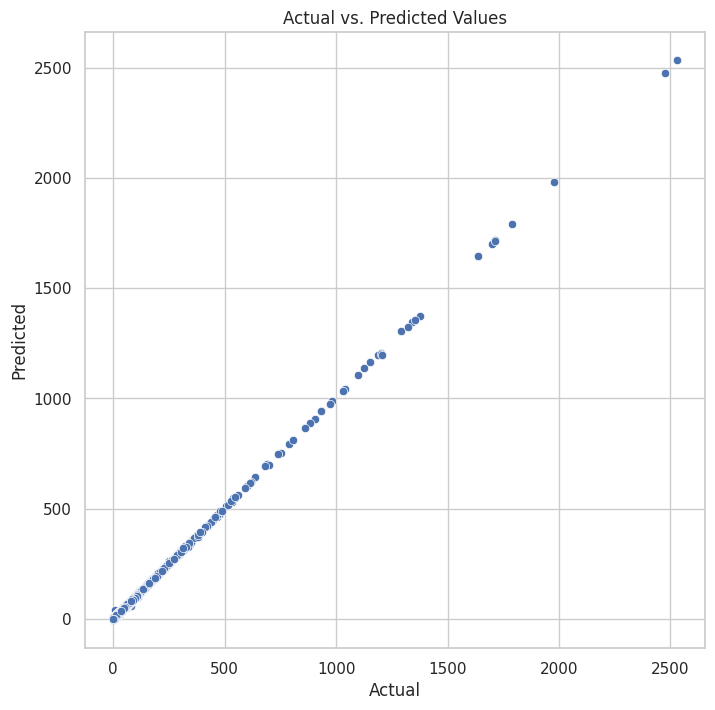

In [ ]:
# Make predictions
y_pred = model.predict(X_test_transformed)

# Plot predicted vs. actual values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_subset, y=y_pred.flatten())
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# 7: Summary <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>


# 8: Future Work <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

# 9: Reference <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

- pandas - https://pandas.pydata.org/docs/
- seaborn - https://seaborn.pydata.org/
- matplotlib - https://matplotlib.org/stable/index.html
- tensorflow - https://www.tensorflow.org/api_docs/python/tf